In [2]:
import yfinance as yf
import pandas as pd

# NIFTY ticker in Yahoo Finance
nifty_ticker = '^NSEI'

# Fetch historical data (past 5 years)
data = yf.download(nifty_ticker, period="5y", interval="1d")
data.dropna(inplace=True)

data.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI
Date,,,,,
2020-04-27,9282.299805,9377.099609,9250.349609,9259.700195,512800
2020-04-28,9380.900391,9404.400391,9260.000000,9389.799805,614500
2020-04-29,9553.349609,9599.849609,9392.349609,9408.599609,653000
2020-04-30,9859.900391,9889.049805,9731.500000,9753.500000,931200
2020-05-04,9293.500000,9533.500000,9266.950195,9533.500000,687500


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta
from sklearn.model_selection import train_test_split

# Step 1: Download NIFTY 50 historical data
data = yf.download("^NSEI", period="5y", interval="1d")
data.dropna(inplace=True)

# Step 2: Flatten column names if needed
if isinstance(data.columns, pd.MultiIndex):
    data.columns = ['_'.join([str(c) for c in col if c]) for col in data.columns]
else:
    data.columns = [str(c) for c in data.columns]

# Step 3: Try to find the 'Close' column automatically
close_col = [col for col in data.columns if 'Close' in col][0]
close = pd.Series(data[close_col].values.flatten(), index=data.index)

# Step 4: Compute technical indicators
data['RSI'] = ta.momentum.RSIIndicator(close=close, window=14).rsi()
macd = ta.trend.MACD(close=close)
data['MACD'] = macd.macd()
data['MACD_signal'] = macd.macd_signal()
bb = ta.volatility.BollingerBands(close=close)
data['BB_high'] = bb.bollinger_hband()
data['BB_low'] = bb.bollinger_lband()
data['SMA20'] = close.rolling(window=20).mean()
data['Volatility'] = close.rolling(window=14).std()

# Step 5: Create target - Direction (1 if market goes up next day, else 0)
data['Return'] = close.pct_change().shift(-1)
data['Direction'] = data['Return'].apply(lambda x: 1 if x > 0 else 0)

# Step 6: Drop any rows with missing values
data.dropna(inplace=True)

# Step 7: Prepare features and labels
features = ['RSI', 'MACD', 'MACD_signal', 'BB_high', 'BB_low', 'SMA20', 'Volatility']
X = data[features]
y = data['Direction']

# Step 8: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("✅ Data is ready!")
print("📊 X_train shape:", X_train.shape)
print("📈 Sample feature columns:", X_train.columns.tolist())


[*********************100%***********************]  1 of 1 completed

✅ Data is ready!
📊 X_train shape: (962, 7)
📈 Sample feature columns: ['RSI', 'MACD', 'MACD_signal', 'BB_high', 'BB_low', 'SMA20', 'Volatility']


/Users/gauraangmalik/.pyenv/versions/3.10.7/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/1h/jzkc4s554818r0wfvp5d90zw0000gn/T/ipykernel_25743/1093468723.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['India_VIX'] = df['India_VIX'].fillna(method='ffill').fillna(method='bfill')
09:41:42 - cmdstanpy - INFO - Chain [1] start processing
09:41:43 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/1h/jzkc4s554818r0wfvp5d90zw0000gn/T/ipykernel_25743/1093468723.py:59: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future.fillna(method='ffill', inplace=True)


✅ RMSE: 326.30
✅ MAE:  151.66


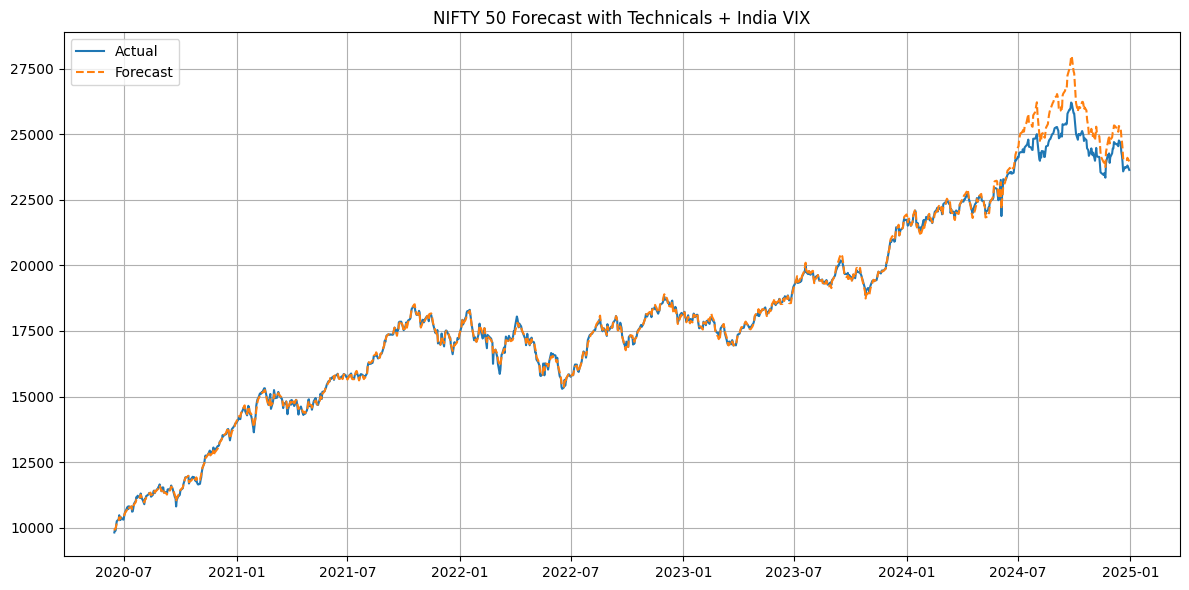

✅ Smoothed Direction Accuracy: 0.9278717720391808

📊 Smoothed Direction Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91       460
           1       0.93      0.95      0.94       663

    accuracy                           0.93      1123
   macro avg       0.93      0.92      0.93      1123
weighted avg       0.93      0.93      0.93      1123



In [4]:
import yfinance as yf
import pandas as pd
from prophet import Prophet
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Download NIFTY 50 data
nifty = yf.Ticker("^NSEI")
df = nifty.history(period="5y", interval="1d")[['Close']]
df.index = df.index.tz_localize(None)
df = df.rename(columns={"Close": "y"}).reset_index().rename(columns={"Date": "ds"})

# Step 2: Download India VIX
vix = yf.Ticker("^INDIAVIX").history(period="5y", interval="1d")[['Close']].rename(columns={'Close': 'India_VIX'})
vix.index = vix.index.tz_localize(None)
vix = vix.reset_index().rename(columns={"Date": "ds"})

# Step 3: Merge VIX into df
df = df.merge(vix, on='ds', how='left')
df['India_VIX'] = df['India_VIX'].fillna(method='ffill').fillna(method='bfill')

# Step 4: Compute technical indicators
close = df['y']
df['RSI'] = RSIIndicator(close, window=14).rsi()
macd = MACD(close)
df['MACD'] = macd.macd()
df['MACD_signal'] = macd.macd_signal()
bb = BollingerBands(close)
df['BB_high'] = bb.bollinger_hband()
df['BB_low'] = bb.bollinger_lband()
df['SMA20'] = close.rolling(window=20).mean()

# Step 5: Drop any remaining NaNs
df.dropna(inplace=True)

# Step 6: Log-transform target
df['y'] = np.log(df['y'])

# Step 7: Train-test split
split_index = int(len(df) * 0.8)
train_df = df[:split_index]
test_df = df[split_index:]

# Step 8: Setup Prophet with technical + VIX regressors
regressors = ['RSI', 'MACD', 'MACD_signal', 'BB_high', 'BB_low', 'SMA20', 'India_VIX']
model = Prophet()
for r in regressors:
    model.add_regressor(r)

model.fit(train_df)

# Step 9: Forecast
future = model.make_future_dataframe(periods=len(test_df), freq='D')
future = future.merge(df[['ds'] + regressors], on='ds', how='left')
future.fillna(method='ffill', inplace=True)
forecast = model.predict(future)

# Step 10: Merge and inverse log-transform
merged = forecast[['ds', 'yhat']].merge(df[['ds', 'y']], on='ds', how='inner')
merged.set_index('ds', inplace=True)
merged['y'] = np.exp(merged['y'])
merged['yhat'] = np.exp(merged['yhat'])

# Step 11: Evaluation
rmse = np.sqrt(mean_squared_error(merged['y'], merged['yhat']))
mae = mean_absolute_error(merged['y'], merged['yhat'])
print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ MAE:  {mae:.2f}")

# Step 12: Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(merged.index, merged['y'], label='Actual')
plt.plot(merged.index, merged['yhat'], label='Forecast', linestyle='--')
plt.title('NIFTY 50 Forecast with Technicals + India VIX')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 13: Smoothed direction prediction
merged['yhat_rolling'] = merged['yhat'].rolling(3).mean()
merged['y_rolling'] = merged['y'].rolling(3).mean()
direction_pred = (merged['yhat_rolling'].diff() > 0).astype(int)[3:]
direction_actual = (merged['y_rolling'].diff() > 0).astype(int)[3:]

# Step 14: Directional accuracy
print("✅ Smoothed Direction Accuracy:", accuracy_score(direction_actual, direction_pred))
print("\n📊 Smoothed Direction Classification Report:\n", classification_report(direction_actual, direction_pred))


In [5]:
import feedparser
from datetime import datetime
import pandas as pd

# Step 1: Parse RSS feed
feed_url = "https://economictimes.indiatimes.com/markets/rssfeeds/1977021501.cms"
feed = feedparser.parse(feed_url)

# Step 2: Extract headlines and dates
news = []
for entry in feed.entries:
    title = entry.title
    published = entry.published
    pub_date = datetime.strptime(published, "%a, %d %b %Y %H:%M:%S %z").date()
    news.append({'ds': pub_date, 'headline': title})

news_df = pd.DataFrame(news)
print(news_df.head())


           ds                                           headline
0  2025-04-25  Equity investors' wealth erodes by Rs 8.88 lak...
1  2025-04-25  RBL Bank Q4 Results: Consolidated profit slump...
2  2025-04-25  Top 5 stocks with increase in retail shareholding
3  2025-04-25  Canara Robeco files draft papers with Sebi for...
4  2025-04-25  These 6 smallcap stocks hit 52-week high and r...


In [6]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Step 1: Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Step 2: Score each headline
news_df['sentiment'] = news_df['headline'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Step 3: Aggregate sentiment score by date
sentiment_df = news_df.groupby('ds')['sentiment'].mean().reset_index()
sentiment_df.rename(columns={'sentiment': 'sentiment_score'}, inplace=True)

# Preview result
print(sentiment_df.head())


           ds  sentiment_score
0  2025-04-25         0.138908


In [7]:
df['ds'] = pd.to_datetime(df['ds']).dt.normalize()
sentiment_df['ds'] = pd.to_datetime(sentiment_df['ds']).dt.normalize()
df = df.merge(sentiment_df, on='ds', how='left')
df['sentiment_score'] = df['sentiment_score'].fillna(0)  # fill missing with neutral



09:43:02 - cmdstanpy - INFO - Chain [1] start processing
09:43:03 - cmdstanpy - INFO - Chain [1] done processing
/Users/gauraangmalik/.pyenv/versions/3.10.7/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/gauraangmalik/.pyenv/versions/3.10.7/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/var/folders/1h/jzkc4s554818r0wfvp5d90zw0000gn/T/ipykernel_25743/3445245861.py:127: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/gauraangmalik/.pyenv/versions/3.10.7/lib/python3.10/site-p

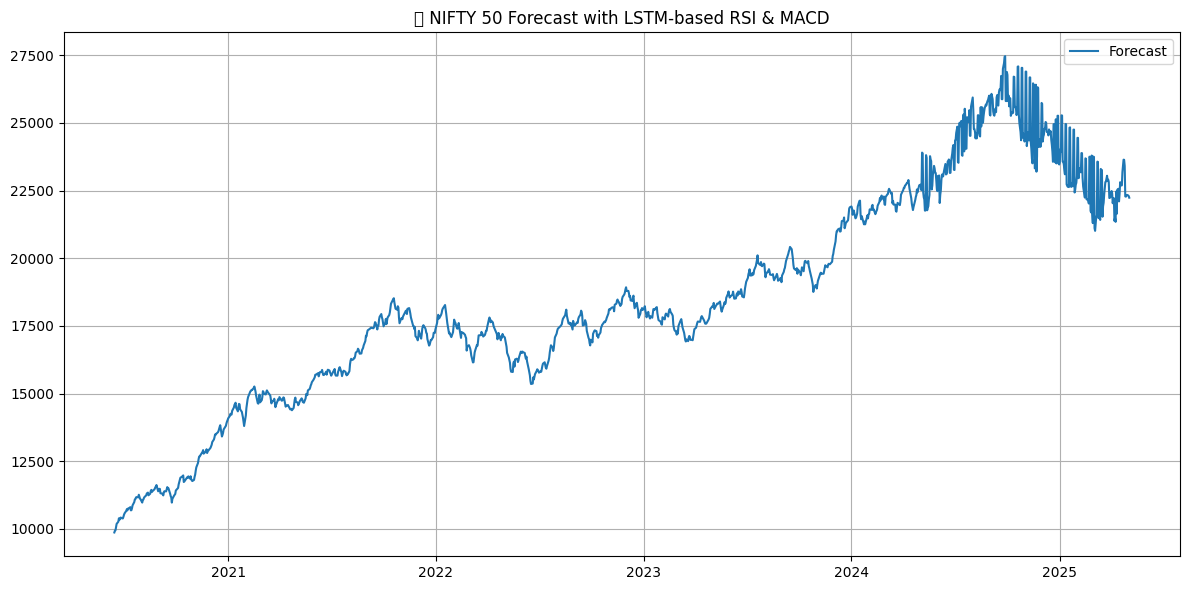

In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
from prophet import Prophet
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import feedparser
from datetime import datetime
import matplotlib.pyplot as plt

# --- Utility Functions ---
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback])
    return np.array(X), np.array(y)

def forecast_lstm_series(series, lookback=30, forecast_horizon=365, epochs=20, name="RSI"):
    series = series.dropna().values.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(series)
    X, y = create_sequences(scaled, lookback)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    model = Sequential([LSTM(50, activation='relu', input_shape=(lookback, 1)), Dense(1)])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    last_seq = scaled[-lookback:].reshape((1, lookback, 1))
    preds = []
    for _ in range(forecast_horizon):
        pred = model.predict(last_seq, verbose=0)[0, 0]
        preds.append(pred)
        last_seq = np.append(last_seq[:, 1:, :], [[[pred]]], axis=1)
    preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
    return preds

# --- Load and Prepare Data ---
nifty = yf.Ticker("^NSEI")
df = nifty.history(period="5y", interval="1d")[['Close']]
df.index = df.index.tz_localize(None)
df = df.rename(columns={"Close": "y"}).reset_index().rename(columns={"Date": "ds"})

# Add India VIX
vix = yf.Ticker("^INDIAVIX").history(period="5y", interval="1d")[['Close']]
vix.index = vix.index.tz_localize(None)
vix = vix.reset_index().rename(columns={"Date": "ds"}).rename(columns={"Close": "India_VIX"})
df = df.merge(vix, on='ds', how='left')
df['India_VIX'] = df['India_VIX'].ffill().bfill()

# Technical indicators
close = df['y']
df['RSI'] = RSIIndicator(close, window=14).rsi()
macd = MACD(close)
df['MACD'] = macd.macd()
df['MACD_signal'] = macd.macd_signal()
bb = BollingerBands(close)
df['BB_high'] = bb.bollinger_hband()
df['BB_low'] = bb.bollinger_lband()
df['SMA20'] = close.rolling(window=20).mean()

# News sentiment
feed_url = "https://economictimes.indiatimes.com/markets/rssfeeds/1977021501.cms"
feed = feedparser.parse(feed_url)
news = []
for entry in feed.entries:
    pub_date = datetime.strptime(entry.published, "%a, %d %b %Y %H:%M:%S %z").date()
    news.append({'ds': pub_date, 'headline': entry.title})
news_df = pd.DataFrame(news)
analyzer = SentimentIntensityAnalyzer()
news_df['sentiment'] = news_df['headline'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
sentiment_df = news_df.groupby('ds')['sentiment'].mean().reset_index().rename(columns={'sentiment': 'sentiment_score'})
df['ds'] = pd.to_datetime(df['ds']).dt.normalize()
sentiment_df['ds'] = pd.to_datetime(sentiment_df['ds']).dt.normalize()
df = df.merge(sentiment_df, on='ds', how='left')
df['sentiment_score'] = df['sentiment_score'].fillna(0)
df.dropna(inplace=True)
df['y'] = np.log(df['y'])

# Prophet setup
regressors = ['RSI', 'MACD', 'MACD_signal', 'BB_high', 'BB_low', 'SMA20', 'India_VIX', 'sentiment_score']
model = Prophet(
    seasonality_mode='multiplicative',
    yearly_seasonality=True,
    weekly_seasonality=True,
    changepoint_prior_scale=0.3,
    changepoint_range=0.95
)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
for r in regressors:
    model.add_regressor(r)

# Train Prophet
train_df = df[:int(len(df) * 0.8)]
model.fit(train_df)

# Build future frame
temp_future = model.make_future_dataframe(periods=365, freq='D')
future_only = temp_future[~temp_future['ds'].isin(df['ds'])]
n_future_days = len(future_only)

# LSTM forecasts
rsi_forecast = forecast_lstm_series(df['RSI'], forecast_horizon=n_future_days, name="RSI")
macd_forecast = forecast_lstm_series(df['MACD'], forecast_horizon=n_future_days, name="MACD")

# Inject into future
future = temp_future.merge(df[['ds'] + regressors], on='ds', how='left')
future.loc[future['ds'].isin(future_only['ds']), 'RSI'] = rsi_forecast
future.loc[future['ds'].isin(future_only['ds']), 'MACD'] = macd_forecast
for col in ['MACD_signal', 'BB_high', 'BB_low', 'SMA20', 'India_VIX', 'sentiment_score']:
    future[col] = future[col].ffill()

# Forecast
forecast = model.predict(future)
forecast['yhat'] = np.exp(forecast['yhat'])

# Plot
plt.figure(figsize=(12, 6))
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
plt.title("🔮 NIFTY 50 Forecast with LSTM-based RSI & MACD")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Export
forecast[['ds', 'yhat']].to_csv("nifty_forecast_with_lstm_indicators.csv", index=False)
